In [1]:
#Import dataframes
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yaml
import os
import json
from tqdm import tqdm
import torch

In [2]:
## Load config file
config = yaml.safe_load(open(f"./config/config.yaml"))

In [3]:
## Options jupyter
# Remove scientific notation for numpy array
np.set_printoptions(precision=2, suppress=True)
# Remove scientific notation in pandas
pd.options.display.float_format = '{:.2f}'.format

In [4]:
sample_size = config['datasets']['sample_size']
pickle_folder = config["datasets"]["pickle_folder"]
final_data_filename = config["datasets"]["final_data_filename"]

final_data_file = f"{final_data_filename}_{sample_size}.pkl"
final_data_location = os.path.join(pickle_folder, final_data_file)
df_raw = pd.read_pickle(final_data_location)
pair_results_filename = config['datasets']['pair_results_filename']
pair_results_filename = os.path.join(pickle_folder, pair_results_filename)

In [41]:
df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
df_raw.columns

Index(['index', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', '_id.$oid', 'author.username',
       'author.created_at', 'author.name', 'public_metrics.retweet_count',
       'public_metrics.reply_count', 'public_metrics.like_count',
       'public_metrics.quote_count', 'author.location', 'referenced_tweets',
       'attachments.media_keys', 'attachments.media', 'geo.place_id',
       'geo.country', 'geo.full_name', 'geo.id', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'attachments.poll_ids',
       'author.withheld.country_codes', 'author.withheld.scope',
       'withheld.copyright', 'withheld.country_codes', 'withheld.scope',
       'event', 'cleaned_text', 'sia_negative', 'sia_positive', 'sia_neutral',
       'sia_compound', 'tb_polarity', 'tb_subjectivity', 'rbta_negative',
       'rbta_neutral', 'rbta_positive', 'rbta_compound', 'anger', 'disgust',
       'fear', 'joy', 'neutral', 'sadness', 'surprise', 'top 

In [42]:
# Read JSON data from a file
#df_pair = pd.read_json('./scripts/pair_result.json')
with open(pair_results_filename, 'r') as json_file:
    json_data = json_file.read()

# Parse JSON data into a dictionary
parsed_list = json.loads(json_data)

In [43]:
full_list = list()
for list_ in parsed_list:
    for i in list_:
        full_list.append(i)
print(len(set(full_list)))

18017


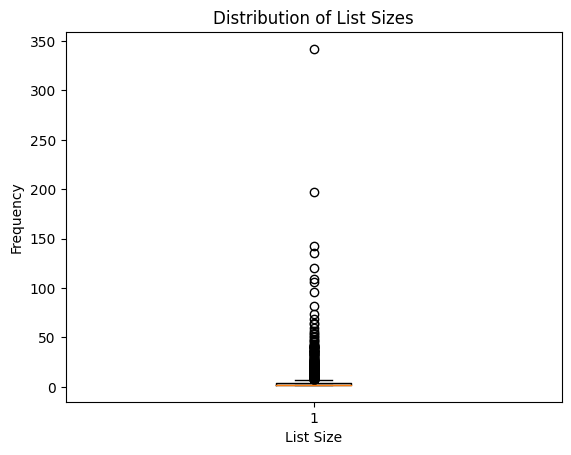

In [44]:
# Get the sizes of the lists
list_sizes = [len(lst) for lst in parsed_list]

# Create a histogram to show the distribution of list sizes
plt.boxplot(list_sizes)
plt.xlabel('List Size')
plt.ylabel('Frequency')
plt.title('Distribution of List Sizes')
plt.show()

In [76]:
list_all_except_first = list()
for index, lst in enumerate(parsed_list):
    all_except_first = df_raw[df_raw['id'].isin(lst)][['id', 'created_at']].sort_values(by='created_at')['id']
    list_all_except_first.extend(all_except_first.iloc[1:])

In [78]:
df_test = df_raw[~df_raw['id'].isin(list_all_except_first)]

In [79]:
df_test

index                   id            author_id      conversation_id  \
0      70050  1575251731515994114                  614  1575251731515994114   
1      78771  1575000474603835392                 1541  1575000474603835392   
2      31173  1443224010930614272                 1541  1443224010930614272   
3      58137  1574874734034034706                 2749  1574874734034034706   
4      83647  1575552603152257025                 4816  1575552603152257025   
...      ...                  ...                  ...                  ...   
92291  51839  1581723015712153601  1581461189023997952  1581723015712153601   
92292  50915  1581773816443043841  1581461189023997952  1581773816443043841   
92293  55497  1581488394022006784  1581483584640192512  1581488394022006784   
92294  50553  1581794416162848768  1581599333937516545  1581794416162848768   
92295  50732  1581783098634559490  1581677807205158913  1581783098634559490   

               created_at edit_history_tweet_ids lang  \
0     2022-09-28 22:30:54  [1575251731515994114]   en   
1     2022-09-28 05:52:29  [1575000474603835392]   en   
2     2021-09-29 14:39:52  [1443224010930614272]   en   
3     2022-09-27 21:32:51  [1574874734034034706]   en   
4     2022-09-29 18:26:27  [1575552603152257025]   en   
...                   ...                    ...  ...   
92291 2022-10-16 19:05:28  [1581723015712153601]   en   
92292 2022-10-16 22:27:20  [1581773816443043841]   en   
92293 2022-10-16 03:33:10  [1581488394022006784]   en   
92294 2022-10-16 23:49:11  [1581794416162848768]   en   
92295 2022-10-16 23:04:13  [1581783098634559490]   en   

                                                    text  \
0      Bingo. And it’s not just the hijab… But birth ...   
1      Womp womp\n\nTexas Attorney General Ken Paxton...   
2      So weird how San Francisco tech bros are movin...   
3      In 2019, #DougMastriano said women who violate...   
4      "It's a really strong step forward if the goal...   
...                                                  ...   
92291  Bad move. You are the party of pedophiles and ...   
92292  When homos care so much about abortion...pedo ...   
92293                                       PRO ABORTION   
92294  Opinion: It's time to launch a counterattack o...   
92295  You should have pressed him on paying for abor...   

                       _id.$oid author.username  ... followers_count  \
0      63998db0a1bce012b5825fd9      dcharrison  ...         2055.00   
1      63998df7a1bce012b582a87b       AdamHertz  ...         2480.00   
2      63998c68a1bce012b5812049       AdamHertz  ...         2480.00   
3      63998d51a1bce012b581fd73       elisaeats  ...          664.00   
4      63998e1ca1bce012b582d08b             EFF  ...       498071.00   
...                         ...             ...  ...             ...   
92291  63998d1ba1bce012b581ca09    SurvivorWoke  ...            6.00   
92292  63998d13a1bce012b581c293    SurvivorWoke  ...            6.00   
92293  63998d39a1bce012b581e7c3        maxiisbi  ...            0.00   
92294  63998d13a1bce012b581bf93      cagifi4220  ...            4.00   
92295  63998d13a1bce012b581c111    BigCrusher10  ...             NaN   

      following_count  tweet_count  listed_count  unknown  female male  \
0             3325.00     29908.00         46.00     0.08    0.51 0.41   
1             1082.00     28326.00        141.00     0.16    0.25 0.59   
2             1082.00     28326.00        141.00     0.16    0.25 0.59   
3              386.00      3172.00         38.00     0.08    0.71 0.21   
4             1063.00     36903.00      13902.00     0.95    0.02 0.03   
...               ...          ...           ...      ...     ...  ...   
92291           22.00       140.00          0.00     0.44    0.38 0.17   
92292           22.00       140.00          0.00     0.44    0.38 0.17   
92293            0.00         4.00          0.00     0.09    0.60 0.31   
92294           31.00      6145.00          0.0

In [46]:
list_username = df_raw[df_raw['id'].isin(full_list)][['author.username']].groupby('author.username').size().sort_values(ascending=False)
list_username.head(25)

author.username
TomthunkitsMind    267
Inspiredtvgh       114
LifeNewsHQ          93
LifeNewsToo         91
gustavokralj        71
gaudiumeng          69
StevenErtelt        62
zhouzhoujyk         61
g_kraig             57
youkayoyo10059      57
littlebytesnews     51
usasharenews        41
realTuckFrumper     40
WeArePatriots2      38
motherslost         36
CAdabag             35
dcexaminer          31
jeguru1             29
JohnRosePutnam      27
LiveActionNews      25
Brospar2022         25
VCPNewz             25
equalearth          24
tellmetimes         23
theliveusa          23
dtype: int64

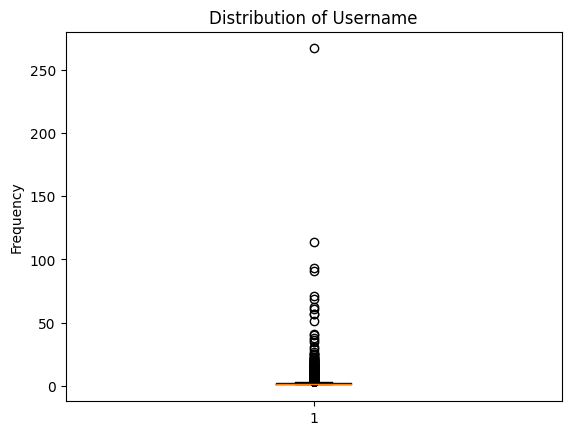

In [9]:
# Create a histogram to show the distribution of list sizes
plt.boxplot(list_username)

plt.ylabel('Frequency')
plt.title('Distribution of Username')
plt.show()